Instructions for setting up conda kernel on NCAR machine:  
- open terminal (e.g., in JupyterHub)
- execute the following series of commands:

`module load conda`  
`conda create -n pyroved`  
`conda activate pyroved`  
`conda install pytorch pyro-ppl pytorch-cuda ipykernel jupyter ipywidgets -c pytorch -c nvidia`  
`pip install pyroved`  

- now you should see a [conda-env:pyroved] conda kernel available when you open a jupyter notebook

In [1]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Test: Shift-VAE example from PyroVED documentation
source: https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/master/examples/shiftVAE.ipynb#scrollTo=8CIc2tL_45qT

In [ ]:
torch.cuda.is_available() # check if GPU accessible

In [20]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

n_samples = 5000 # number of samples
l_signal = 100 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
torch.manual_seed(1)  # for reproducibility
x = torch.linspace(-12, 12, l_signal).expand(n_samples, l_signal)
noise = torch.randint(1, 100, (n_samples, 1)) / 1e3
mu = torch.randint(-30, 30, size=(n_samples, 1)) / 10
sig = torch.randint(50, 500, size=(n_samples, 1)) / 1e2
train_data = gaussian(x, mu, sig) + noise * torch.randn(size=(n_samples, l_signal))
# Normalize to (0, 1)
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

In [22]:
train_data.dtype

torch.float32

In [ ]:
train_data.shape

In [ ]:
test = train_data.unsqueeze(1)
test.shape

In [ ]:
train_loader

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x[0], y[0, 0])

In [ ]:
in_dim = (100,)

# Initialize vanilla VAE
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    if e % 10 == 0: # only print every 10 epochs
        trainer.print_statistics()

In [ ]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel(r"$z_2$", fontsize=14)
ax1.set_ylabel(r"$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label(r"$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig)
ax2.set_xlabel(r"$z_2$", fontsize=14)
ax2.set_ylabel(r"$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label(r"$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

In [ ]:
vae.manifold2d(d=10);

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(z_mean[:, 0], mu, c='blue')
ax[0, 0].set_xlabel(r"$\mu$", fontsize=14)
ax[0, 0].set_ylabel("Latent variable 1", fontsize=14)
ax[0, 1].scatter(z_mean[:, 1], mu, c='blue')
ax[0, 1].set_xlabel(r"$\mu$", fontsize=14)
ax[0, 1].set_ylabel("Latent variable 2", fontsize=14)
ax[1, 0].scatter(z_mean[:, 0], sig, c='blue')
ax[1, 0].set_xlabel(r"$\sigma$", fontsize=14)
ax[1, 0].set_ylabel("Latent variable 1", fontsize=14)
ax[1, 1].scatter(z_mean[:, 1], sig, c='blue')
ax[1, 1].set_xlabel(r"$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("Latent variable 2", fontsize=14);

In [ ]:
in_dim = (100,)

# Initialize shift-invariant VAE (to do this we add 't' to invariances)
svae = pv.models.iVAE(in_dim, latent_dim=2, invariances=['t'], dx_prior=.3)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(svae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    if e % 10 == 0: # only print every 10 epochs
        trainer.print_statistics()

In [ ]:
z_mean, z_sd = svae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel(r"$z_1$", fontsize=14)
ax1.set_ylabel(r"$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label(r"$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig)
ax2.set_xlabel(r"$z_1$", fontsize=14)
ax2.set_ylabel(r"$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label(r"$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

In [ ]:
svae.manifold2d(d=10);

In [ ]:
rescale = ((x.max() - x.min()) / 2 ) * svae.t_prior.cpu() # rescaling coefficient for shift latent variable
i = 2 # non-collapsed latent variable 
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.5, 6))
ax1.scatter(mu, z_mean[:, 0] * rescale, c='blue', label="Encoded shift")
ax1.scatter(mu, mu, label="Actual shift")
ax1.set_xlabel(r"$\mu$", fontsize=14)
ax1.set_ylabel("Encoded shift", fontsize=14)
ax1.legend()
ax1.grid()
ax2.scatter(sig, z_mean[:, i], c='blue')
ax2.set_xlabel(r"$\sigma$", fontsize=14)
ax2.set_ylabel("Latent variable {}".format(i), fontsize=14)
ax2.grid()

# Example: Using our traj data

In [28]:
filepath = '/glade/work/psturm/ice-mp-su24/saved_trajectory_data/rh_trajectories_Ns10000.csv'
rh_trajectories = pd.read_csv(filepath)
rh_trajectories = rh_trajectories.dropna()
# make the index rk_deact
rh_trajectories = rh_trajectories.set_index('rk_deact')
# convert to numpy array
supersaturation = (rh_trajectories.to_numpy()-1)

array([[-0.00017105, -0.00299866, -0.00510401, ...,  0.02552565,
         0.01616653,  0.03445953],
       [ 0.00405934,  0.00064997,  0.02542396, ...,  0.04647774,
         0.02760952,  0.0278568 ],
       [ 0.0038512 ,  0.00370279,  0.00477981, ...,  0.00212237,
         0.00151531,  0.00127326],
       ...,
       [ 0.04300803,  0.03695587,  0.08955983, ...,  0.02454756,
         0.01963112,  0.01735622],
       [ 0.01162949,  0.01643006,  0.04423646, ...,  0.02254812,
         0.01625997,  0.0103029 ],
       [ 0.02157191,  0.02156081,  0.02162602, ...,  0.02014012,
         0.02157531,  0.02408111]])

In [29]:
# convert data to tensor
train_data = torch.from_numpy(supersaturation)
train_data = train_data.to(torch.float32) # change data type for compatibility with package
print(type(train_data))
print(train_data.shape)
print(train_data.dtype)

<class 'torch.Tensor'>
torch.Size([9916, 36])
torch.float32


In [30]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

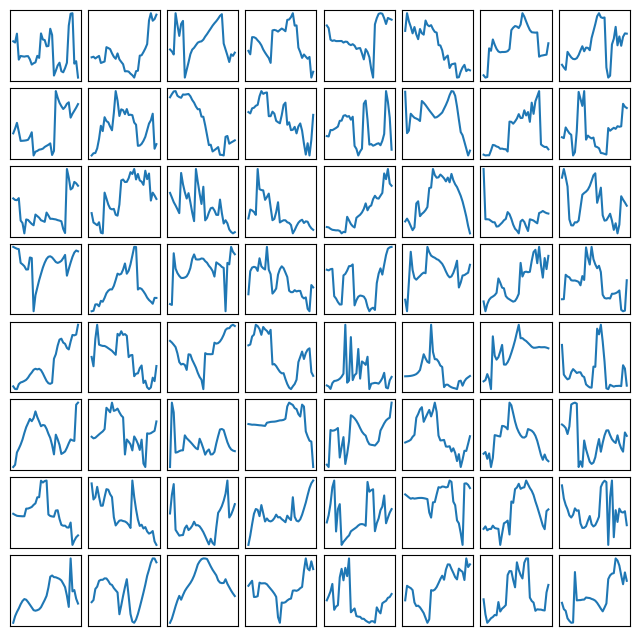

In [32]:
# visualize sample of trajs
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(y[0, 0])

In [33]:
# Train the VAE (no invariance)
in_dim = (36,)

# Initialize vanilla VAE
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    if (e+1) % 10 == 0:
        trainer.print_statistics()

Epoch: 10 Training loss: 0.7056
Epoch: 20 Training loss: 0.6292
Epoch: 30 Training loss: 0.6058
Epoch: 40 Training loss: 0.5594
Epoch: 50 Training loss: 0.5191
Epoch: 60 Training loss: 0.5162
Epoch: 70 Training loss: 0.4993
Epoch: 80 Training loss: 0.5022
Epoch: 90 Training loss: 0.4950
Epoch: 100 Training loss: 0.4845
Epoch: 110 Training loss: 0.4888
Epoch: 120 Training loss: 0.4834
Epoch: 130 Training loss: 0.4841
Epoch: 140 Training loss: 0.4780
Epoch: 150 Training loss: 0.4862
Epoch: 160 Training loss: 0.4711
Epoch: 170 Training loss: 0.4808
Epoch: 180 Training loss: 0.4719
Epoch: 190 Training loss: 0.4736
Epoch: 200 Training loss: 0.4761
Epoch: 210 Training loss: 0.4707
Epoch: 220 Training loss: 0.4776
Epoch: 230 Training loss: 0.4725
Epoch: 240 Training loss: 0.4707
Epoch: 250 Training loss: 0.4678


Text(0, 0.5, '$z_1$')

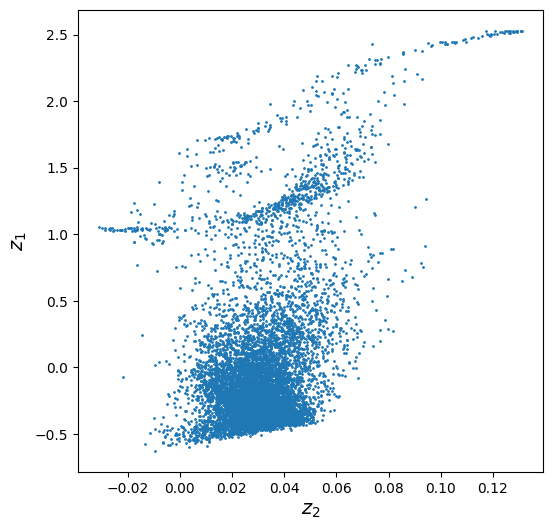

In [39]:
# plot scatter plot in latent space
z_mean, z_sd = vae.encode(train_data)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.scatter(z_mean[:, -1], z_mean[:, -2], s=1)
ax.set_xlabel(r"$z_2$", fontsize=14)
ax.set_ylabel(r"$z_1$", fontsize=14)

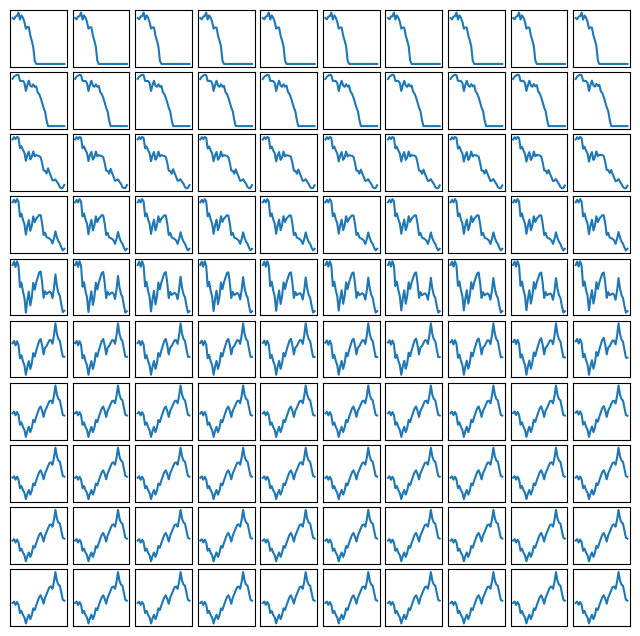

In [41]:
vae.manifold2d(d=10);